# Problem statement

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

# Dataset

The dataset has been uploaded to Kagglge - https://www.kaggle.com/datasets/kk20krishna/skin-cancer-data-isic

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.


The data set contains the following diseases:

- Actinic keratosis
- Basal cell carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented benign keratosis
- Seborrheic keratosis
- Squamous cell carcinoma
- Vascular lesion

# Housekeeping

In [ ]:
!pip install Augmentor

In [ ]:
import Augmentor
import shutil
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import kagglehub
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, \
    AveragePooling2D, GlobalAveragePooling2D, Dense, RandomFlip, RandomRotation, RandomZoom, Input, Lambda, Multiply, RandomTranslation, RandomBrightness, RandomContrast, Dropout, Flatten
from tensorflow.keras.models import Model

# Import specific callback functions from Keras for model training callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Data

## Reading Data

Download data from Kaggle

In [ ]:
download_path = kagglehub.dataset_download("kk20krishna/skin-cancer-data-isic")
download_path = pathlib.Path(download_path)
print("Path to downloaded files:", download_path)

working_path = pathlib.Path("/content")
print('\nWorking Path: ', working_path)

try:
    shutil.rmtree(working_path)
    print(f"Folder '{working_path}' deleted successfully.")
except FileNotFoundError:
    print(f"Folder '{working_path}' not found.")
except OSError as e:
    print(f"Error deleting folder '{working_path}': {e}")

# Copy the entire directory structure
shutil.copytree(download_path, working_path, dirs_exist_ok=True)

print(f"\nAll files copied from {download_path} to {working_path}")

data_dir = list(working_path.glob('*'))[0]
data_dir_train = data_dir / 'Train'
data_dir_test = data_dir / 'Test'

print("\nTrain Folder: ", data_dir_train)
print("Test Folder: ", data_dir_test)

print("\nNo. of Train images: :", len(list(data_dir_train.glob('*/*.jpg'))))
print("No. of Test images: :", len(list(data_dir_test.glob('*/*.jpg'))))

100%|██████████| 786M/786M [00:40<00:00, 20.3MB/s]

Extracting files...


Path to downloaded files: /root/.cache/kagglehub/datasets/kk20krishna/skin-cancer-data-isic/versions/1

Working Path:  /content
Folder '/content' deleted successfully.

All files copied from /root/.cache/kagglehub/datasets/kk20krishna/skin-cancer-data-isic/versions/1 to /content

Train Folder:  /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train
Test Folder:  /content/Skin cancer ISIC The International Skin Imaging Collaboration/Test

No. of Train images: : 2239
No. of Test images: : 118


## Dataset visualisation

Visualize four images for each for the nine classes

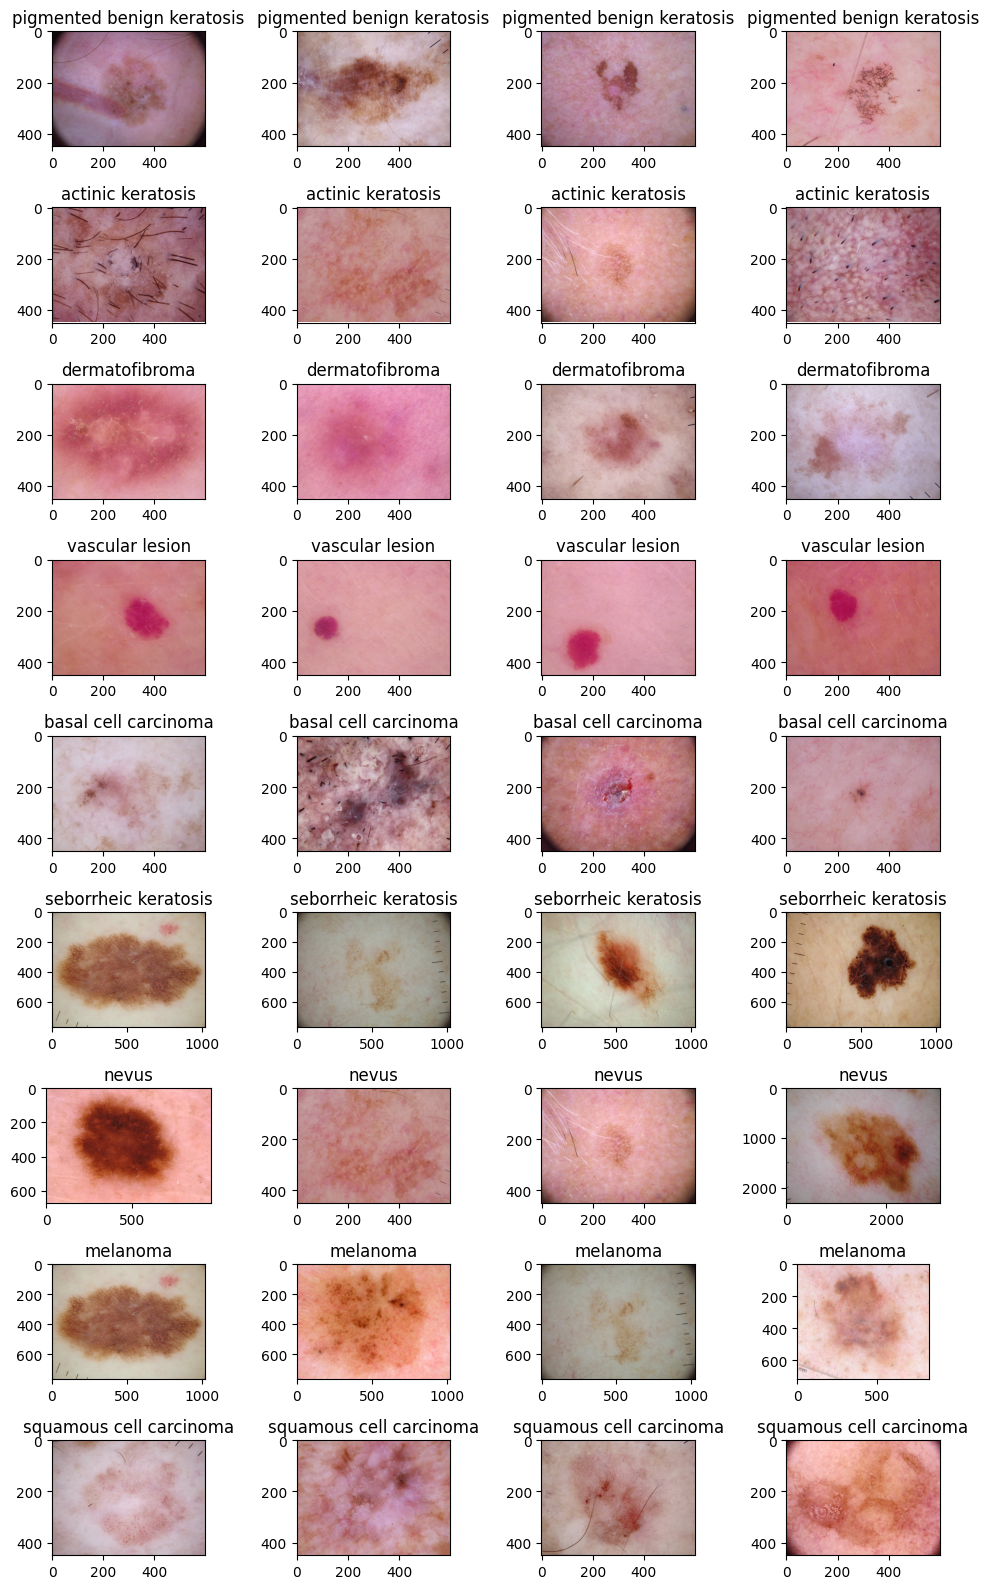

In [ ]:
fig, axes = plt.subplots(9, 4, figsize=(10, 16))

for i, folder in enumerate(data_dir_train.iterdir()):
  for j, file in enumerate(folder.iterdir()):
    if j <= 3:
      # print image in file
      img = PIL.Image.open(file)
      axes[i, j].imshow(img)
      axes[i, j].set_title(folder.name)

plt.tight_layout()

plt.show()

## Class Distribution

Let us look at the class distibution of the data. We will look at how many images are presnet for each of the 9 classes.

In [ ]:
def dir_analysis():
    """
    Analyzes the distribution of images in training and test datasets.

    This function iterates through the directories containing training and test images,
    counts the number of images in each class (subdirectory), and visualizes the distribution
    using horizontal bar charts.
    """
    # Extract the number of images and corresponding class names for the training set
    labels, values = zip(*[(len(list(folder.glob('**/*'))), folder.name) for folder in data_dir_train.iterdir()])

    # Create a figure with two subplots for train and test datasets
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle('Number of Images per Class in Datasets')

    # Plot the training data distribution
    ax1.barh(values, labels)
    ax1.set_xlabel("Classes")
    ax1.set_ylabel("Number of Images")
    ax1.set_title("Train")

    # Extract the number of images and corresponding class names for the test set
    labels, values = zip(*[(len(list(folder.glob('**/*'))), folder.name) for folder in data_dir_test.iterdir()])

    # Plot the test data distribution
    ax2.barh(values, labels)
    ax2.set_xlabel("Classes")
    ax2.set_ylabel("Number of Images")
    ax2.set_title("Test")

    # Adjust layout for better spacing
    fig.tight_layout()

    # Display the plots
    plt.show()

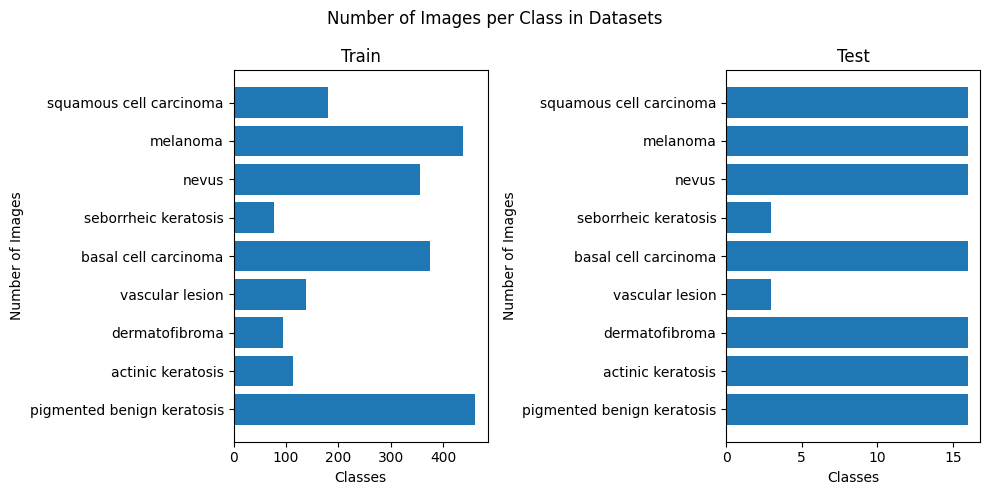

In [ ]:
dir_analysis()

**Class with the least number of samples:**
- In the Train dataset, "seborrheic keratosis" has the fewest images.

**Classes that dominate the dataset:**
- "Pigmented benign keratosis" has the highest number of images in the Train dataset.
- "Melanoma" and "Nevus" also have a large proportion of samples.

**We can see that the data has class imbalance.**
Class imbalance occurs when certain classes have significantly more samples than others. In the provided dataset, we observe that some categories, such as pigmented benign keratosis and melanoma, have a substantially higher number of images compared to others like seborrheic keratosis and vascular lesion.

**Potential Impacts of Class Imbalance**

- Class imbalance can have serious consequences on the performance of machine learning models, particularly deep learning models such as CNNs:

- Bias Towards Majority Classes - The model may learn to predict the majority class more frequently, leading to poor generalization for minority classes.

- Poor Model Performance - Metrics such as accuracy may be misleading, as the model could achieve high accuracy by simply predicting the dominant classes.

- Higher False Negatives - For medical datasets, missing minority class predictions can be critical, potentially leading to misdiagnoses.

**Addressing Class Imbalance Using Augmentor**

- **We will handle class imbalance through data augmentation**, which increases the number of samples in underrepresented classes. The Augmentor library is a powerful tool that allows for systematic augmentation of image datasets.


## Expanding Training Data

Data augmentation not only helps balance classes but also expands the overall training dataset and improves model generalization.

**We will use Augmentor to expand the training data by applying a transformation pipeline.**

**Benefits:**

- **Increased Training Data** - Synthetic data helps train the model on more diverse examples, reducing the risk of overfitting.

- **Enhanced Data Variety** - Random transformations introduce variations that improve the model's robustness to real-world scenarios.

- **Reduced Overfitting** - The model generalizes better to unseen data instead of memorizing patterns from limited samples.

## Apply Augmentation

Apply augmentation to the training data to:
1. handle class imbalance
2. expand training data

We will apply augmentation using the Augementor library.
> https://augmentor.readthedocs.io/en/master/




In [ ]:
# Augmentation

# Iterate through each folder in the training dataset
for folder in data_dir_train.iterdir():

    # Determine the number of augmentation samples based on existing data size
    if len(list(folder.glob('*'))) > 250:
        # Generate addiational images for minority classes
        aug_samples = 1400  # If there are more than 250 files, use 1400 augmentation samples
    else:
        aug_samples = 1800  # Otherwise, use 1800 augmentation samples

    # Define augmentation pipeline
    aug = Augmentor.Pipeline(folder)

    # Apply a series of augmentation transformations
    aug.rotate(probability=0.6, max_left_rotation=20, max_right_rotation=20)
    aug.flip_left_right(probability=0.6)
    aug.flip_top_bottom(probability=0.6)
    aug.random_brightness(probability=0.5, min_factor=0.8, max_factor=1.2)
    aug.random_contrast(probability=0.5, min_factor=0.8, max_factor=1.2)

    # Execute the pipeline (generate augmented images)
    aug.sample(aug_samples)

Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A30DA413110>: 100%|██████████| 1400/1400 [00:42<00:00, 32.86 Samples/s]


Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A316FB75ED0>: 100%|██████████| 1800/1800 [00:55<00:00, 32.17 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A30DA413110>: 100%|██████████| 1800/1800 [00:55<00:00, 32.42 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A30D9EC4D50>: 100%|██████████| 1800/1800 [00:54<00:00, 33.01 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A30D81AAE50>: 100%|██████████| 1400/1400 [00:43<00:00, 32.46 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A30DA85B510>: 100%|██████████| 1800/1800 [02:10<00:00, 13.82 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7A316F587090>: 100%|██████████| 1400/1400 [03:25<00:00,  6.81 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A30D9F5A0D0>: 100%|██████████| 1400/1400 [03:40<00:00,  6.34 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A30D9D1BAD0>: 100%|██████████| 1800/1800 [00:55<00:00, 32.35 Samples/s]


Let us take a look at a sample of the augmented images for Melanoma class

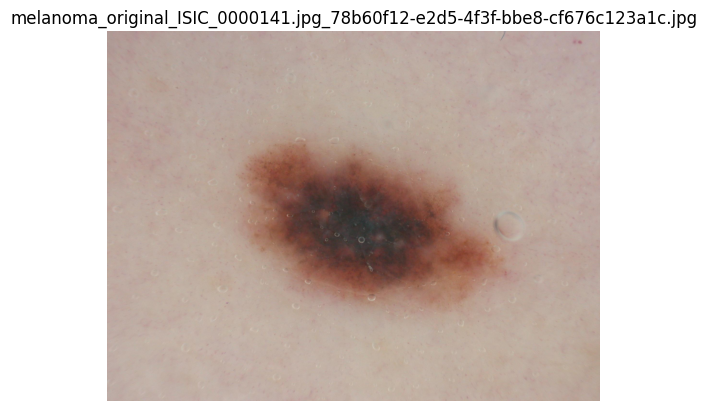

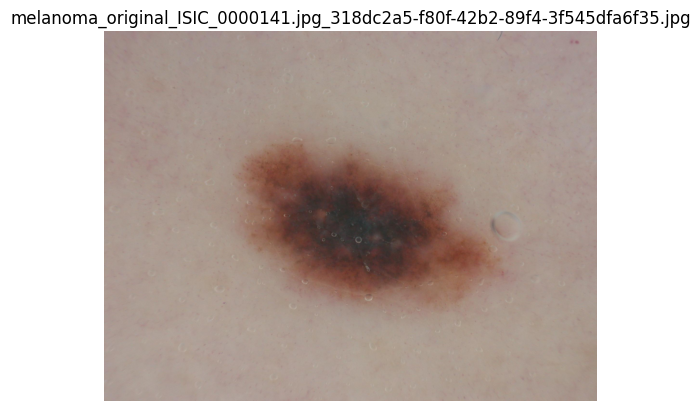

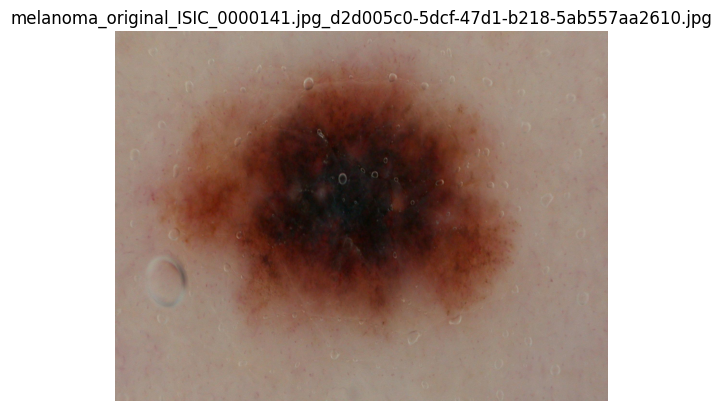

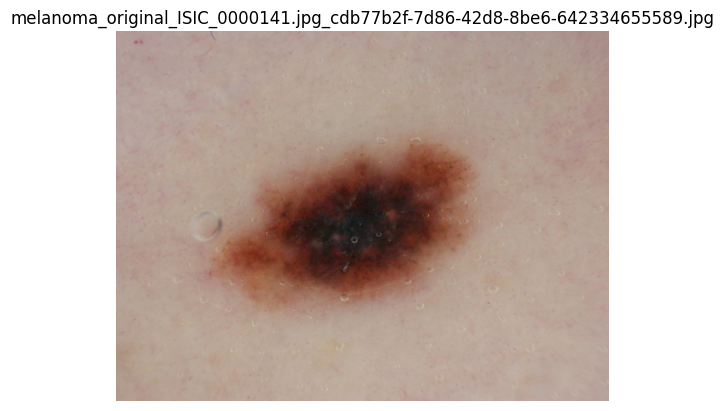

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

image_folder = "/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output"
search_term = "ISIC_0000141"

# Find and display images
for filename in os.listdir(image_folder):
    if search_term in filename:
        image_path = os.path.join(image_folder, filename)
        try:
            img = Image.open(image_path)
            plt.imshow(img)
            plt.axis('off')  # Hide axes
            plt.title(filename)
            plt.show()
        except Exception as e:
            print(f"Error displaying image {filename}: {e}")


**Re-evaluate Class Distribution:**

After augmentation, visualize the dataset again to confirm a more balanced distribution.

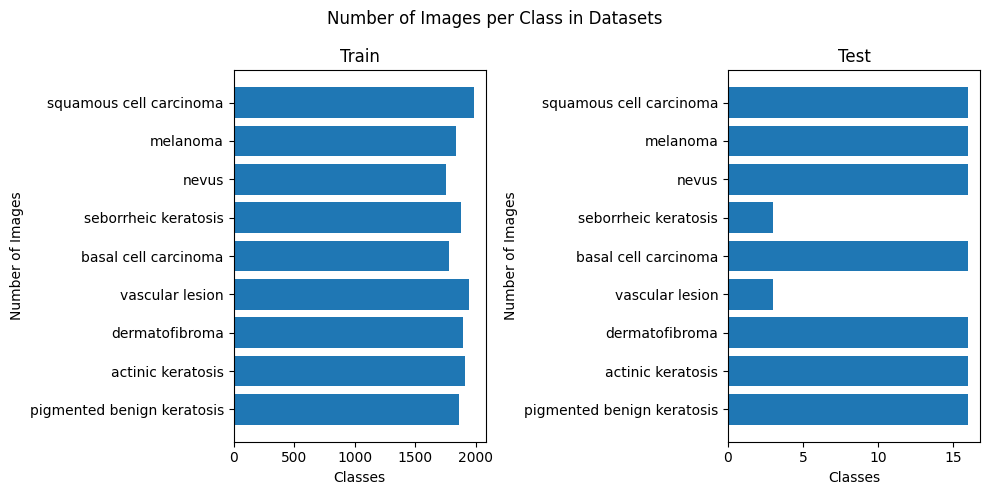

In [ ]:
dir_analysis()

In [ ]:
print("\nNo. of Train images: :", len(list(data_dir_train.glob('**/*.jpg'))))
print("No. of Test images: :", len(list(data_dir_test.glob('**/*.jpg'))))


No. of Train images: : 16839
No. of Test images: : 118


**Class imbalance is now addressed.** All classes have about the same amout of samples.

**The training data also has been expanded.**

# Create dataset

Create train and test dataset

In [ ]:
train_dataset, val_dataset = keras.utils.image_dataset_from_directory(
    data_dir_train,                # Path to the training data directory
    label_mode='categorical',       # Labels will be one-hot encoded (useful for multi-class classification)
    validation_split=0.2,           # 20% of data will be used for validation
    subset="both",                  # Splits the dataset into both training and validation sets
    image_size=(180, 180),          # Resizes images to 180x180 pixels
    seed=44                         # Ensures reproducibility by fixing the random seed, also needs to be used when creating train and val datasets together
)

Found 16839 files belonging to 9 classes.
Using 13472 files for training.
Using 3367 files for validation.


In [ ]:
train_dataset.element_spec

(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))

Print 4 images from train dataset

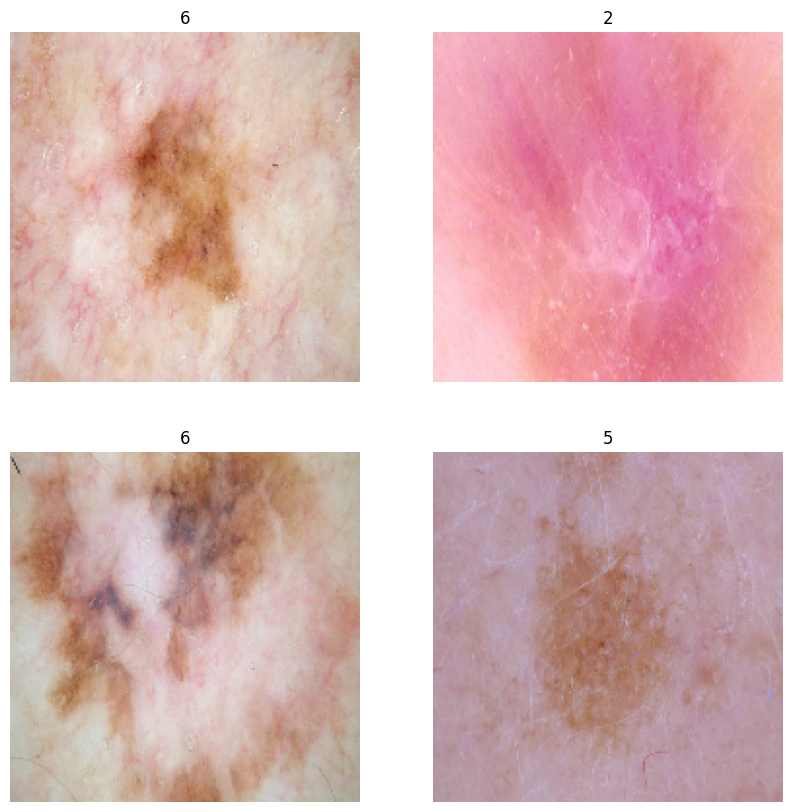

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(np.argmax(labels[i]))
    plt.axis("off")


# CNN Model

## Design Model

**Cancer Classification Model Design**

**Model Architecture**

This Convolutional Neural Network (CNN) is designed to classify images into 9 distinct cancer classes. The input images have a resolution of 180x180 pixels with 3 color channels (RGB).

Below, the design choices made for this model are explained:

1. **Input Preprocessing**
  - **Rescaling:** The input pixel values are normalized to the range [0,1] using `Rescaling(scale=1./255)`. This helps in stabilizing the learning process by ensuring smaller gradients during training.

2. **Feature Extraction using Convolutional Blocks**
The model consists of four convolutional blocks, each having:
      1. **Conv2D Layer**: Extracts spatial features using 3x3 filters with 'same' padding to maintain spatial dimensions.
      2. **ReLU Activation**: Introduces non-linearity, allowing the model to learn complex patterns.
      3. **MaxPooling Layer**: Reduces spatial dimensions and computational cost while preserving important features.

  - **First Convolutional Block:**
    - 32 filters, 3x3 kernel, ReLU activation, 'same' padding.
    - Followed by MaxPooling to reduce spatial size.

  - **Second Convolutional Block:**
    - 64 filters, 3x3 kernel, ReLU activation, 'same' padding.
    - Followed by MaxPooling.

  - **Third Convolutional Block:**
    - 128 filters, 3x3 kernel, ReLU activation, 'same' padding.
    - Followed by MaxPooling.

  - **Fourth Convolutional Block:**
    - 256 filters, 3x3 kernel, ReLU activation, 'same' padding.
    - Followed by MaxPooling.

3. **Regularization using Dropout**
  - A **Dropout layer (50%)** is introduced after the fourth convolutional block to reduce overfitting by randomly setting neuron outputs to zero during training.

4. **Fully Connected Layers**
  - **Flatten Layer**: Converts the feature maps into a 1D vector.
  - **Dense Layer with 128 neurons (ReLU activation)**: Helps in learning complex feature representations.
  - **Dropout Layer (50%)**: Provides additional regularization.

5. **Output Layer**
  - **Dense Layer with 9 neurons**: Uses Softmax activation to output probabilities for the 9 cancer classes.

> *Below architecture diagram has been created using https://alexlenail.me/NN-SVG/AlexNet.html*



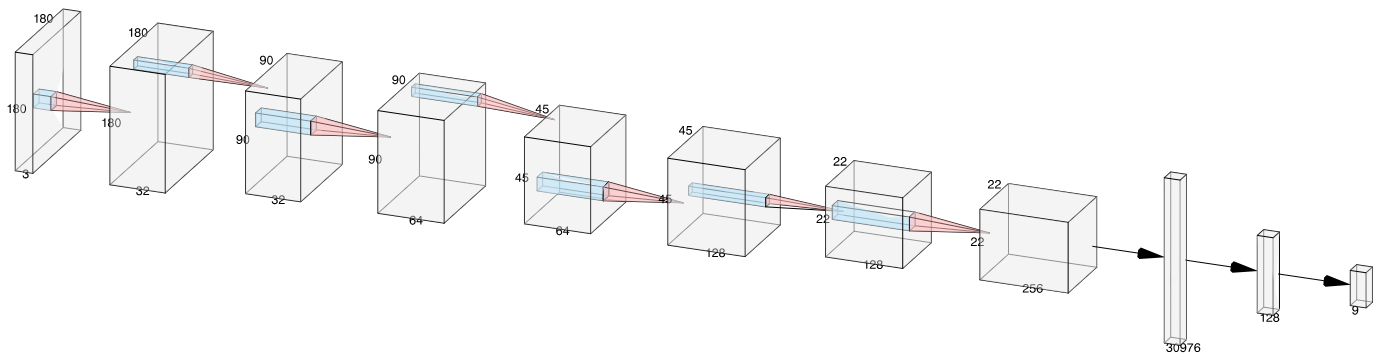

## Define Model

In [ ]:
# Define the input shape for the model (180x180 RGB images)
inputs = Input(shape=(180, 180, 3))

# Rescale pixel values to range [0,1] by dividing by 255
x = keras.layers.Rescaling(scale=1./255, name="rescale")(inputs)

# First Convolutional Block:
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D()(x)

# Second Convolutional Block:
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D()(x)

# Third Convolutional Block:
x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D()(x)

# Fourth Convolutional Block:
x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D()(x)

# Dropout layer to prevent overfitting (50% dropout rate)
x = Dropout(0.5)(x)

# Flatten the feature map into a 1D vector
x = Flatten()(x)

# Fully Connected Layer:
x = Dense(128, activation='relu')(x)

# Dropout layer to prevent overfitting (50% dropout rate)
x = Dropout(0.5)(x)

# Output Layer:
x = Dense(9, activation="softmax")(x)

# Define the Model
model = tf.keras.Model(inputs, x, name="Cancer_classification")


## Compile Model

Defined 'adam' optimiser and 'categorical_crossentropy' loss function for model training.



In [ ]:
# Compile
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy', 'precision', 'recall', 'f1_score'])

## Model Summary

In [ ]:
# Summary
model.summary()

Model: "Cancer_classification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescale (Rescaling)                  │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,354,633 (16.61 MB)

 Trainable params: 4,354,633 (16.61 MB)

 Non-trainable params: 0 (0.00 B)

##  Model checkpoint, early stopping and learning control

In [ ]:
# ModelCheckpoint saves the model during training based on performance.
checkpoint = ModelCheckpoint(
    "/content/Melanoma_Detection_Model.keras",  # Filepath to save the model.
    monitor="val_accuracy",  # Monitor validation accuracy to decide when to save.
    save_best_only=True,     # Save only the model with the best validation accuracy.
    mode="auto",             # Automatically determines whether to minimize or maximize the monitored metric.
    verbose=1                # Print a message when the model is saved.
)

# EarlyStopping stops training when a monitored metric stops improving.
earlystop = EarlyStopping(
    monitor="val_accuracy",  # Monitor validation accuracy to detect stagnation.
    patience=10,             # Wait for 10 epochs without improvement before stopping training.
    mode="auto",             # Automatically determines whether to minimize or maximize the monitored metric.
    verbose=1                # Print a message when training stops.
)

# ReduceLROnPlateau is a callback that reduces the learning rate when a metric has stopped improving.
learn_control = ReduceLROnPlateau(
    monitor='val_accuracy',  # Monitor validation accuracy to determine when to reduce the learning rate.
    patience=5,              # Wait for 5 epochs without improvement before reducing the learning rate.
    verbose=1,               # Print messages when the learning rate is reduced.
    factor=0.2,              # Reduce the learning rate by a factor of 0.2 (new_lr = current_lr * 0.2).
    min_lr=1e-7              # Set a lower bound on the learning rate to prevent it from becoming too small.
)

## Configure dataset for GPU usage

In [ ]:
# Define the appropriate number of processes that are free for working using AUTOTUNE
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Cache the training dataset in memory after loading images from disk during the first epoch. This helps improve data loading speed for subsequent epochs
train_dataset = train_dataset.cache()

# Shuffle the training dataset to introduce randomness during training and prevent the model from memorizing the order of examples
train_dataset = train_dataset.shuffle(1000)

# Prefetch data for training to overlap data preprocessing and model execution
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

# Cache the validation dataset in memory
val_dataset = val_dataset.cache()

# Prefetch data for validation
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

# Fit Model

**Note** that there we are not limiting the number of epochs, we are using a lare number of epocs during fit, and are using early stopping to stop training when model performance is not improving in successive epochs

In [ ]:
history = model.fit(
    train_dataset,    # Training dataset used for model learning
    validation_data=val_dataset,  # Validation dataset to monitor model performance during training
    epochs=100,       # Number of times the model will go through the entire dataset
    callbacks=[
        checkpoint,   # Saves model checkpoints to prevent loss of progress
        earlystop,    # Stops training early if validation loss stops improving
        learn_control # Adjusts learning rate dynamically based on performance
    ]
)

Epoch 1/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1837 - f1_score: 0.1683 - loss: 2.0948 - precision: 0.5881 - recall: 0.0340
Epoch 1: val_accuracy improved from -inf to 0.43362, saving model to /content/Melanoma_Detection_Model.keras
421/421 ━━━━━━━━━━━━━━━━━━━━ 85s 70ms/step - accuracy: 0.1839 - f1_score: 0.1685 - loss: 2.0943 - precision: 0.5884 - recall: 0.0341 - val_accuracy: 0.4336 - val_f1_score: 0.3975 - val_loss: 1.4483 - val_precision: 0.7357 - val_recall: 0.1604 - learning_rate: 0.0010
Epoch 2/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3864 - f1_score: 0.3828 - loss: 1.5428 - precision: 0.6622 - recall: 0.1512
Epoch 2: val_accuracy did not improve from 0.43362
421/421 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - accuracy: 0.3864 - f1_score: 0.3829 - loss: 1.5427 - precision: 0.6623 - recall: 0.1513 - val_accuracy: 0.4301 - val_f1_score: 0.4076 - val_loss: 1.5166 - val_precision: 0.7855 - val_recall: 0.1675 - learning_rate: 0.0010
Epoch 3/100
421/42

# Evaluate Model

## Accuracy, Loss, Precision, Loss, Recall and F1

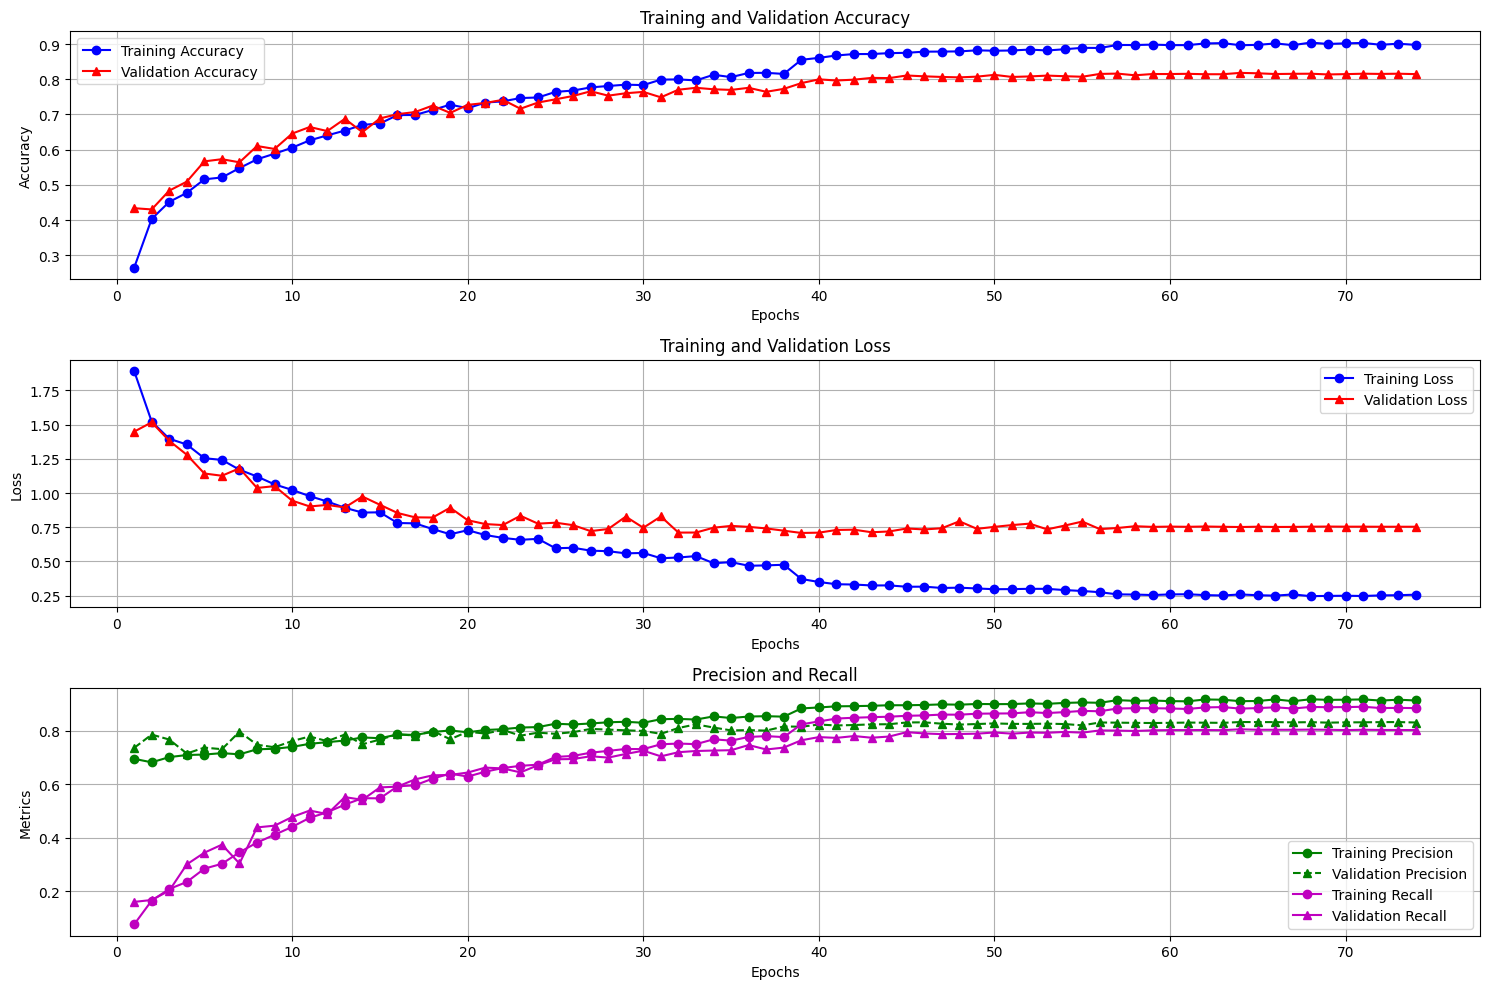

In [ ]:
import matplotlib.pyplot as plt

# Extract metrics from history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['precision']
val_precision = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']
f1_score = history.history['f1_score']
val_f1_score = history.history['val_f1_score']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15, 10))

# 1. Plot training and validation accuracy
plt.subplot(3, 1, 1)  # 3 rows, 1 column, first subplot
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r^-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 2. Plot training and validation loss
plt.subplot(3, 1, 2)  # 3 rows, 1 column, second subplot
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r^-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 3. Plot precision and recall
plt.subplot(3, 1, 3)  # 3 rows, 1 column, third subplot
plt.plot(epochs, precision, 'go-', label='Training Precision')
plt.plot(epochs, val_precision, 'g^--', label='Validation Precision')
plt.plot(epochs, recall, 'mo-', label='Training Recall')
plt.plot(epochs, val_recall, 'm^-', label='Validation Recall')
plt.title('Precision and Recall')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


There no significant in crease in performance observed after 40 epochs. 50 Epochs would be a good number if this training is conducted in a resource constrained environment.

**Note** that there we are not limiting the number of epochs, we are using a lare number of epocs during fit, and are using early stopping to stop training.

## Validation dataset dataset Confusion Matrix

Now let us create the confusion matrix on the validation dataset and analyze how the model performed for each of the 9 classes.

Class Names:  ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


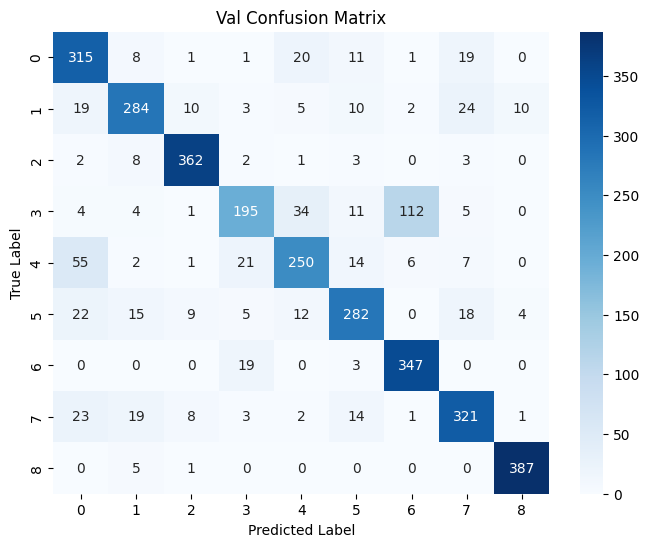

In [ ]:
# Extract labels from dataset
val_labels = np.concatenate([y.numpy() for _, y in val_dataset])

y_true = val_labels.argmax(axis=1)  # Convert one-hot to class indices
y_pred = model.predict(val_dataset).argmax(axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Val Confusion Matrix")
plt.show()

**Class-wise Analysis**
1.  Actinic Keratosis (Class 0)
  -  Correctly classified: 315  
  -  Misclassified as:  
      - 'Nevus' (19 times)  
      - 'Pigmented Benign Keratosis' (20 times)  
  -  Insight: Some confusion with 'Nevus' and 'Pigmented Benign Keratosis.'

2.  Basal Cell Carcinoma (Class 1)
  -  Correctly classified: 284  
  -  Misclassified as:  
      - 'Dermatofibroma' (10 times)  
      - 'Nevus' (24 times)  
  -  Insight: Some misclassification with 'Nevus.'

3.  Dermatofibroma (Class 2)
  -  Correctly classified: 362  
  -  Insight: Model performs well on this class with minimal misclassification.

4.  **Melanoma (Class 3)**
  -  **Correctly classified: 195**
  -  **Misclassified as:**  
      - **'Nevus' (112 times)**  
      - **'Pigmented Benign Keratosis' (34 times)**  
  -  **Insight: Significant confusion with 'Nevus.'**

5.  Nevus (Class 4)
  - Correctly classified: 250  
  - Misclassified as:  
      - 'Actinic Keratosis' (55 times)  
      - 'Pigmented Benign Keratosis' (21 times)  
  -  Insight: The highest misclassification with 'Actinic Keratosis.'

6.  Pigmented Benign Keratosis (Class 5)
  -  Correctly classified: 282  
  -  Misclassified as:  
      - 'Basal Cell Carcinoma' (15 times)  
      - 'Nevus' (12 times)  
  -  Insight: Moderate misclassification.

7.  Seborrheic Keratosis (Class 6)
  -  Correctly classified: 347  
  -  Insight: Model performs very well on this class.

8.  Squamous Cell Carcinoma (Class 7)
  -  Correctly classified: 321  
  -  Misclassified as:  
      - 'Actinic Keratosis' (23 times)  
      - 'Basal Cell Carcinoma' (19 times)  
  - Insight: Some overlap with 'Actinic Keratosis.'

9.  Vascular Lesion (Class 8)
  -  Correctly classified: 387  
  -  Almost no misclassification.  
  -  Insight: Model performs excellently for this class.

---

**Key Takeaways**
-  'Nevus' and 'Melanoma' have the highest confusion. This makes sense since melanoma can visually resemble a nevus.
- 'Actinic Keratosis' is often confused with 'Squamous Cell Carcinoma' and 'Nevus.'
- 'Vascular Lesion' and 'Seborrheic Keratosis' show strong classification performance.
- 'Melanoma' misclassification is concerning since early detection is critical for treatment.

## Evaluate Model on test dataset

In [ ]:
test_dataset = keras.utils.image_dataset_from_directory(
    data_dir_test,
    label_mode='categorical',
    image_size=(180, 180),
    shuffle=False  # Important: Don't shuffle test data
)

Found 118 files belonging to 9 classes.


In [ ]:
# Evaluate the model on the test dataset
results = model.evaluate(test_dataset)

# Print the results (loss and accuracy)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.3856 - f1_score: 0.2735 - loss: 9.0061 - precision: 0.4002 - recall: 0.3856
Test Loss: 8.707498550415039
Test Accuracy: 0.4406779706478119


## Test Data Confusion Matrix

Class Names:  ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


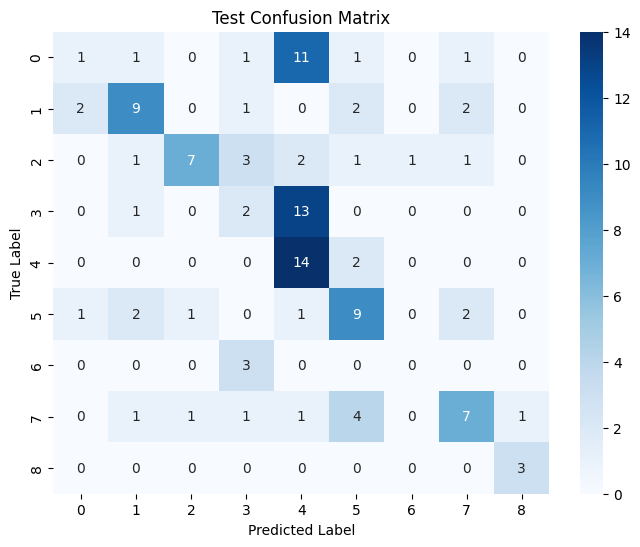

In [ ]:
print("Class Names: ", test_dataset.class_names)

# Extract labels from dataset
test_labels = np.concatenate([y.numpy() for _, y in test_dataset])

y_true = test_labels.argmax(axis=1)  # Convert one-hot to class indices
y_pred = model.predict(test_dataset).argmax(axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Test Confusion Matrix")
plt.show()

# Conclusion

**1. Overview**
This report provides an evaluation of the Convolutional Neural Network (CNN) model trained for melanoma detection and cancer classification. The evaluation metrics include accuracy, precision, recall, F1-score, and loss for both training and validation datasets.

**2. Performance Metrics**

- **Training Performance**
  - Final Training Accuracy: 90.08%
  - Final Training F1-score: 89.83%
  - Final Training Precision: 91.81%
  - Final Training Recall: 88.71%
  - Final Training Loss: 0.2508

- **Validation Performance**
  - Best Validation Accuracy: 81.82%
  - Final Validation Accuracy: 81.47%
  - Final Validation F1-score: 80.88%
  - Final Validation Precision: 83.06%
  - Final Validation Recall: 80.22%
  - Final Validation Loss: 0.7534

**3. Training vs Validation Trends**

- **Accuracy**
  - Training accuracy remained consistently above 89%.
  - Validation accuracy fluctuated between 81% and 82%, peaking at 81.82%.
  - The gap between training and validation accuracy suggests minor overfitting.

- **F1-score**
  - Training F1-score improved steadily, reaching 89.83%.
  - Validation F1-score stabilized around 80.88%, indicating the model maintains good balance in classification.

- **Loss Analysis**
  - Training loss steadily decreased to **0.2508**, showing good convergence.
  - Validation loss plateaued around **0.75**, indicating room for further generalization improvements.


- **4. Learning Rate Analysis**
  - The final learning rate decay suggests the model was approaching optimal convergence.


- **5. Observations**
  - **Slight Overfitting**: The training accuracy is higher than validation accuracy, indicating overfitting. Consider applying stronger regularization techniques such as dropout, weight decay, or data augmentation.
  - **Validation Performance Plateau**: Validation accuracy remained stable around **81%**, indicating that performance improvements may require architectural modifications or additional data.
  - **Early Stopping Activation**: Training stopped at **epoch 74**, suggesting further training would not yield significant improvements.


- **6. Conclusion**
  The model achieved **90.08% training accuracy** and **81.82% best validation accuracy** for cancer detection.